# Lab14-2_Assignment

## Requirment:

- Implement the Improved WGAN.
- Train the Improved WGAN on CelebA dataset.
- Build dataset that read and resize images to 64 x 64 for training.
- Show a gif of generated samples (at least 8 x 8)
- Draw the loss curve of discriminator and generator during training process into one image.
- Write a brief report

## Report:

### 1. reading images
- total # = 202599 images

### 2. write input images into tf_record
- 轉成tf.train.BytesList

### 3. resize images to 64 x 64 and normalize them for training

### 4. Imporve WGAN
- params和lab14-2提供的improve WGAN的參數一樣：
- beta_1 = 0, beta_2 = 0.9, lambda = 10

### 5. Show a GIF

### 6. Draw the loss curve

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 200
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUFFER = 20000

# learning rate in IWGAN picture
IMPROVED_W_LR = 1e-4
IMPROVED_W_EPOCH = 256

ITEMS_PER_FILE = 2000

2021-12-21 15:41:09.715141: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the specified GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        ''' 在8G M1上跑的話要調1024(1G)左右才勉強能跑 '''
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 0x2000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2021-12-21 15:41:10.619874: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-21 15:41:10.657465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 15:41:10.657938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-12-21 15:41:10.657958: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-21 15:41:10.659676: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-21 15:41:10.659713: I tensorflow/stream_executor/pl

### 0. Utility Function

In [3]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

### 1. Read images

In [4]:
img_names = []

for i in range(1,202600):
    img_name = str(i)
    pad_zero = str(0)*(6-len(img_name))
    img_name = pad_zero + img_name + '.png'
    img_names.append(img_name)

In [5]:
DATA_PATH = './input/datalab-lab-14-2/' #'./img_align_celeba_png/'

def load_img(img_name):
    raw_img = tf.io.read_file(DATA_PATH + img_name)
    return raw_img

In [6]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [7]:
def serialize_example(img):
    feature = {
        'img': _bytes_feature(img)
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [8]:
def tf_serialize_example(img):
    tf_string = tf.py_function(
        serialize_example,
        [img],
        tf.string)
    return tf.reshape(tf_string, ())

### 2. Write input images into tf_record 

In [9]:
num=0
## 轉成tfrecord
for i in range(0,len(img_names),ITEMS_PER_FILE):
    raw_image_data = tf.data.Dataset.from_tensor_slices(img_names[i:i+ITEMS_PER_FILE])
    raw_image_data = raw_image_data.map(load_img,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    serialized_features_dataset = raw_image_data.map(tf_serialize_example,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    filename = f'./input/google/train_tfrecord/train_{num:03d}_.tfrecord'
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(serialized_features_dataset)
    num+=1


2021-12-21 15:41:11.154342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-21 15:41:11.176282: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592000000 Hz


### 3. resize images to 64 x 64 and normalize them for training

In [10]:
def processing(raw_img):
    img = tf.image.decode_png(raw_img, channels=3)
    # resize inputs into 64x64!
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img,tf.float32)
    # normalization
    img = img / 255.
    return img

In [11]:
filename_list = []
for i in range(102):
    filename_list.append(f'./input/google/train_tfrecord/train_{i:03d}_.tfrecord') #(f'./train_tfrecord/train_{i:03d}_.tfrecord')
raw_dataset_train = tf.data.TFRecordDataset(filename_list)
raw_dataset_train

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [12]:
feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    return parsed['img']

In [13]:
parsed_dataset_train = raw_dataset_train.map(_parse_function)
dsTrain = parsed_dataset_train.map(processing)
dsTrain = dsTrain.shuffle(BUFFER)

In [14]:
# number_of_img = 0
# for img in dsTrain:
#     if number_of_img == 2:
#         break
#     plt.imshow(img.numpy())
#     plt.axis("off")
#     plt.show()
#     number_of_img+=1

In [15]:
dsTrain = dsTrain.batch(BATCH_SIZE,drop_remainder=True)
dsTrain = dsTrain.prefetch(200)

### 4. Imporve WGAN

In [16]:
''' same with lab14-2 '''
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [17]:
# from IPython.core.display import Image, display
# display(Image('14-2_GAN_files/IWGAN algorithm.jpg', height = 600, width=1000, unconfined=True))

#### set beta_1 = 0, beta_2 = 0.9, lambda = 10

In [18]:
IMPROVED_WG, IMPROVED_WD = GAN(IMG_SHAPE, Z_DIM)

## 用Adam，而不是RMSprop
optimizer_g = keras.optimizers.Adam(learning_rate=IMPROVED_W_LR,beta_1=0.,beta_2=0.9)
optimizer_d = keras.optimizers.Adam(learning_rate=IMPROVED_W_LR,beta_1=0.,beta_2=0.9)

In [19]:
@tf.function
def WGTrain(c1):
    # 先random選embedding z
    z = tf.random.normal(BZ)
    with tf.GradientTape() as tpg:
        with tf.GradientTape() as tp_gradientpenalty:
            # line 5
            x_bar = IMPROVED_WG(z, training = True)
            # line 6: random choose epsilon from 0~1, x: grong truth image
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            # line 7: send x, x_bar, x_hat into
            # first term: D_w(x_bar)
            z0 = IMPROVED_WD(x_bar, training = True)
            # second term
            z1 = IMPROVED_WD(x, training = True)
            # third term
            penalty = IMPROVED_WD(x_hat, training = True)
            gradient_penalty = tp_gradientpenalty.gradient(penalty,x_hat)
            ## L2 norm
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            ## lambda = 10
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_g = tpg.gradient(lg, IMPROVED_WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, IMPROVED_WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)
    with tf.GradientTape() as tpd:
        with tf.GradientTape() as tp_gradientpenalty:
            x_bar = IMPROVED_WG(z, training = True)

            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            z1 = IMPROVED_WD(x, training = True)
            z0 = IMPROVED_WD(x_bar, training = True)
            penalty = IMPROVED_WD(x_hat, training = True)
            gradient_penalty = tp_gradientpenalty.gradient(penalty,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_d = tpd.gradient(ld, IMPROVED_WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, IMPROVED_WD.trainable_variables))
    
    return lg, ld

In [20]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

#### check point

In [21]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(IMPROVED_WG = IMPROVED_WG,
                           IMPROVED_WD = IMPROVED_WD,
                           optimizer_g = optimizer_g,
                           optimizer_d = optimizer_d)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [22]:
from tqdm import tqdm 
from tqdm.notebook import tqdm_notebook

### Training

  0%|                                                   | 0/256 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2021-12-21 15:42:00.174811: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-21 15:42:02.940111: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-12-21 15:42:02.940286: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-21 15:42:02.979915: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-12-21 15:42:03.771561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-12-21 15:42:04.913043: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-21 15:42:04.913074: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-12-21 15:42:04.913608: E tensorf

0it [00:00, ?it/s]

  1%|▎                                        | 2/256 [02:51<5:59:16, 84.87s/it]

0it [00:00, ?it/s]

  1%|▍                                        | 3/256 [04:12<5:51:38, 83.39s/it]

0it [00:00, ?it/s]

  2%|▋                                        | 4/256 [05:34<5:47:28, 82.73s/it]

0it [00:00, ?it/s]

  2%|▊                                        | 5/256 [06:55<5:43:57, 82.22s/it]

0it [00:00, ?it/s]

  2%|▉                                        | 6/256 [08:17<5:41:28, 81.95s/it]

0it [00:00, ?it/s]

  3%|█                                        | 7/256 [09:38<5:39:20, 81.77s/it]

0it [00:00, ?it/s]

  3%|█▎                                       | 8/256 [10:59<5:37:09, 81.57s/it]

0it [00:00, ?it/s]

  4%|█▍                                       | 9/256 [12:20<5:35:11, 81.42s/it]

0it [00:00, ?it/s]

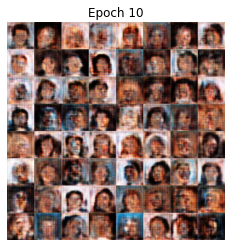

  4%|█▌                                      | 10/256 [13:44<5:35:55, 81.93s/it]

0it [00:00, ?it/s]

In [ ]:
''' same with lab14-2 '''
wlg = [None] * IMPROVED_W_EPOCH #record loss of g for each epoch
wld = [None] * IMPROVED_W_EPOCH #record loss of d for each epoch
wsp = [None] * IMPROVED_W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(img_names))
ctr = 0
for ep in tqdm(range(IMPROVED_W_EPOCH)):
    print("Epoch: " + str(ep+1), end='\r')
    lgt = 0.0
    ldt = 0.0
    #for idx, c1 in enumerate(dsTrain):
    for idx, c1 in tqdm_notebook(enumerate(dsTrain)):
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    with open('./wlg.txt','a') as f:
        f.write(str(lgt * rsTrain) + '\n')
    f.close()
    with open('./wld.txt','a') as f:
        f.write(str(ldt * rsTrain) + '\n')
    f.close()
    
    out = IMPROVED_WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "./output/google/assignment_imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 10 == 0: 
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % (ep+1))
        plt.show()
    if (ep+1) % 10 == 0: 
        ckpt_manager.save()

### 5. GIF

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

def load_generated_img(path):
    image = load_img(path)
    data = img_to_array(image).astype(np.uint8)
    return data

In [ ]:
img_gan_gen = load_generated_img('./output/google/assignment_imgs/w_0252.png')
print(type(img_gan_gen))
plt.imshow(img_gan_gen)
plt.axis("off")
plt.show()

In [ ]:
utMakeGif(np.array(wsp), "./output/google/imgs/wgan.gif", duration = 2)

### 6. Draw loss curve

In [ ]:
wld = []
wlg = []
with open('./wld.txt') as f:
    lines = f.readlines()
    f.close()
for line in lines:
    wld.append(float(line.strip('\n')))
    
with open('./wlg.txt') as f:
    lines = f.readlines()
    f.close()
for line in lines:
    wlg.append(float(line.strip('\n')))

In [ ]:
plt.plot(range(IMPROVED_W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(IMPROVED_W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "lower left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()